# Building Code Documentation Agents with CrewAI

[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2qNXgLMuzlJ8LS8Kl30EXbGwxSh)

Deploy with Launchables. Launchables are pre-configured, fully optimized environments that users can deploy with a single click.


This notebook demonstrates how to create a crew of multiple Agents for writing documentation using CrewAI Flows.
The crew will analyze code from any public GitHub repository and generate comprehensive documentation
by working collaboratively using specialized agents with different roles and responsibilities.
CrewAI Flows enable coordinated execution and communication between agents to produce high-quality
documentation for any codebase.

You will use NVIDIA NIM Microservices for the LLM, llama 3.3 70B. In addition, NeMo Retriever E5 embedding NIM, is used. 

You can get started by leveraging NVIDIA API Catalog and call a hosted model's NIM API Endpoint. Once you familiarize yourself with this blueprint, you may want to self-host models with NVIDIA NIM Microservices.

Here's an architecture diagram of the workflow.
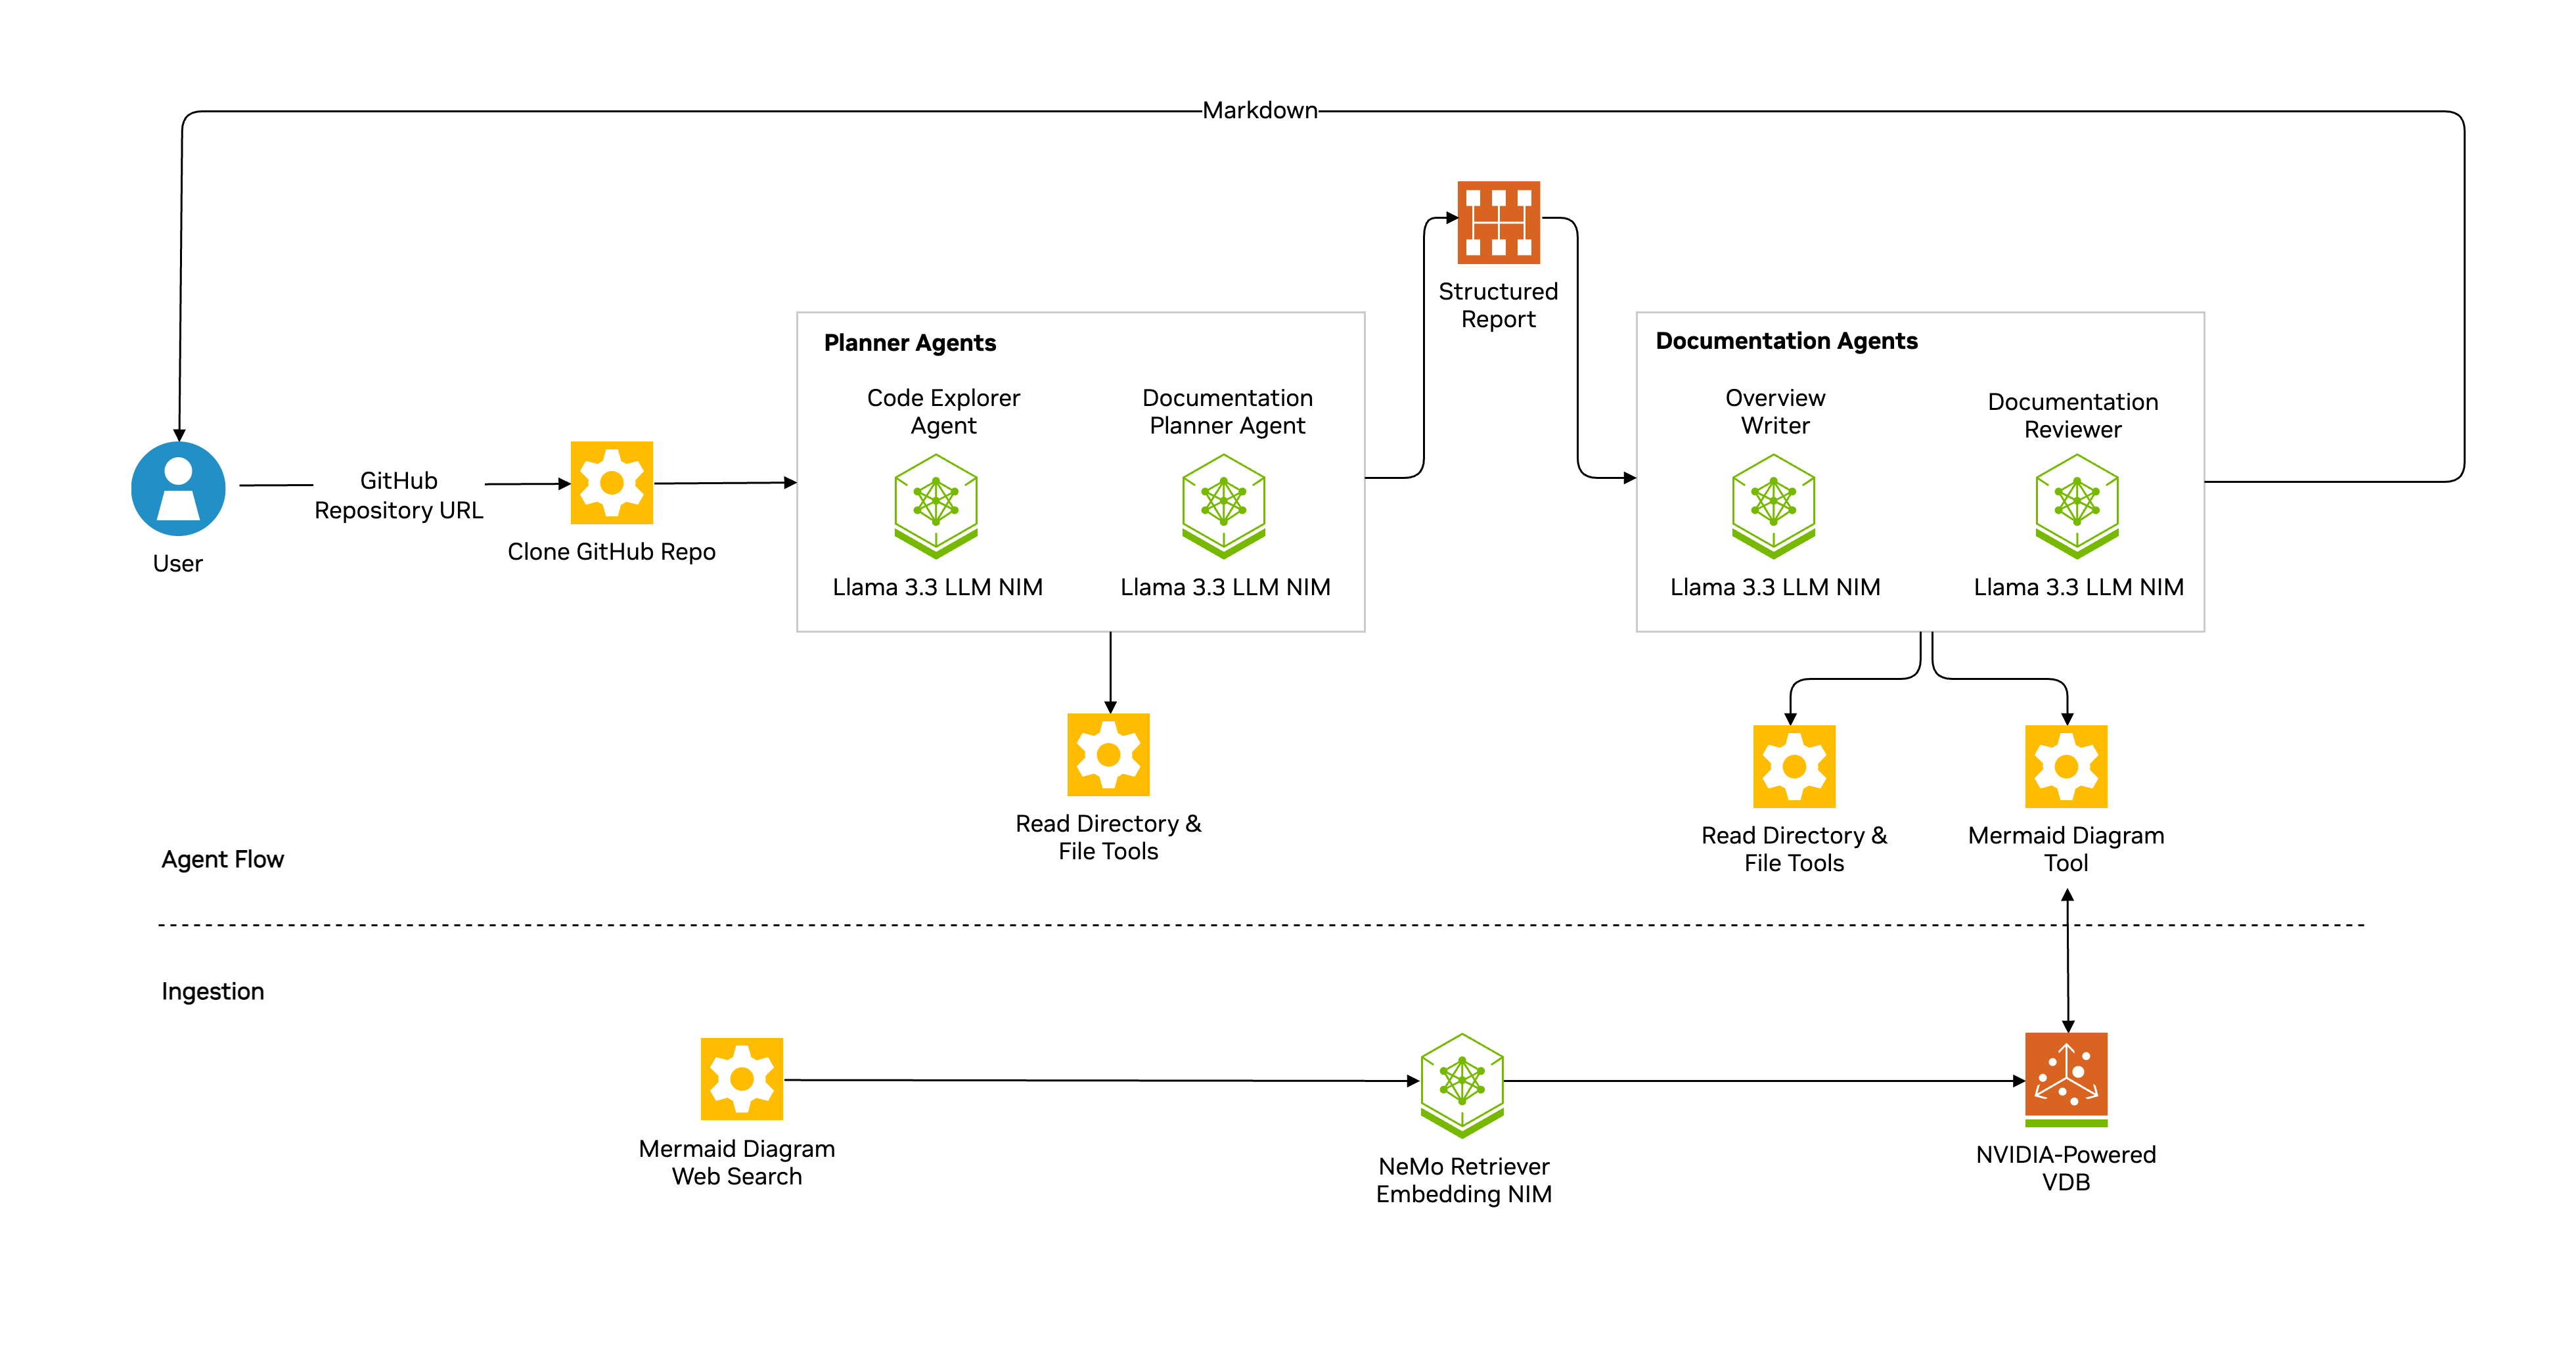

**The system employs a multi-agent workflow divided into two key stages:**

#### Ingestion Phase
- **WebsiteSearchTool:** This tool is used to embed and index mermaid examples from mermaid.js.org website using NVIDIA NeMo Retriever E5 embedding NIM.

#### Agent Flow
1. Codebase Analysis and Strategy Planning:
    - Analyze Codebase: Planner agents inspect the repository to map its structure, identify key components, and understand interdependencies.
    - Develop Strategy: They create a tailored documentation plan based on the analysis.
2. Documentation Creation and Review:
    - High-Level Documentation: One agent generates clear, comprehensive documentation introducing the project and its architecture.
    - Quality Assurance: Another agent ensures accuracy, consistency, and completeness across all documentation.



# Content Overview
>[Prerequisites](#Prerequisites)  
>[Define the project URL](#Define-the-project-URL)  
>[Create Planning Crew](#Create-Planning-Crew)  
>[Create Documentation Crew](#Create-Documentation-Crew)  
>[Run Documentation Flow](#Run-Documentation-Flow)  
________________________


## Prerequisites 

### API Keys
Prior to getting started, you will need to create API Keys for the NVIDIA API Catalog

- Navigate to [NVIDIA API Catalog](https://build.nvidia.com/meta/llama-3_3-70b-instruct)
- On the right panel above the sample code snippet, click on "Build with this NIM".
- This will prompt you to log in if you have not already.

### Install Dependencies

In [ ]:
# Create reusable loading animation class
import os
import sys
import time
import threading

class LoadingAnimation:
    def __init__(self):
        self.stop_event = threading.Event()
        self.animation_thread = None

    def _animate(self, message="Loading"):
        chars = "/—\\|"
        while not self.stop_event.is_set():
            for char in chars:
                sys.stdout.write('\r' + message + '... ' + char)
                sys.stdout.flush()
                time.sleep(0.1)
                if self.stop_event.is_set():
                    sys.stdout.write("\n")
                    break

    def start(self, message="Loading"):
        self.stop_event.clear()
        self.animation_thread = threading.Thread(target=self._animate, args=(message,))
        self.animation_thread.daemon = True
        self.animation_thread.start()

    def stop(self, completion_message="Complete"):
        self.stop_event.set()
        if self.animation_thread:
            self.animation_thread.join()
        print(f"\r{completion_message} ✓")

# Use the animation for pip install
loader = LoadingAnimation()
loader.start("Installing")
%pip install -r requirements.txt -q
loader.stop("Installation complete")

### Helper Functions

In [2]:
import dotenv
from dotenv import dotenv_values

# Define a fake `load_dotenv` function
def _load_dotenv(*args, **kwargs):
    env_path = kwargs.get('dotenv_path', '.env')  # Default to '.env'
    parsed_env = dotenv_values(env_path)

    # Manually set valid key-value pairs
    for key, value in parsed_env.items():
        if key and value:  # Check for valid key-value pairs
            os.environ[key] = value

dotenv.load_dotenv = _load_dotenv

### Initialization and Setup
Initial imports for the CrewAI Flow and Crew and setting up the environment

In [3]:
# Importing necessary libraries
import yaml
import subprocess
from pathlib import Path
from pydantic import BaseModel

# Importing Crew related components
from crewai import Agent, Task, Crew

# Importing CrewAI Flow related components
from crewai.flow.flow import Flow, listen, start

# Apply a patch to allow nested asyncio loops in Jupyter
import nest_asyncio
nest_asyncio.apply()

## API Keys
Prior to getting started, you will need to create API Keys for the NVIDIA API Catalog.

- NVIDIA API Catalog
  1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.
  2. Select any model, such as llama-3.3-70b-instruct.
  3. On the right panel above the sample code snippet, click on "Get API Key". This will prompt you to log in if you have not already.

### Export API Keys

Save this API Key as environment variables.


In [ ]:
import getpass

if not os.environ.get("NVIDIA_NIM_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_NIM_API_KEY"] = nvapi_key
    os.environ["NVIDIA_API_KEY"] = nvapi_key

print(f"NVIDIA API Key: {os.environ['NVIDIA_API_KEY']}")
print(f"NVIDIA NIM API Key: {os.environ['NVIDIA_NIM_API_KEY']}")


### Working with the NVIDIA API Catalog
Let's test the API endpoint. The NVIDIA NIM Microservices used in this notebook are llama-3.3-70b and an NVIDIA text embedding model, nv-embedqa-e5-v5. These are models are defined in the yaml files in the `config` directory if you're looking for them!

In [ ]:
from crewai import LLM

loader = LoadingAnimation()
loader.start("Calling NVIDIA NIM")

llm = LLM(model="nvidia_nim/meta/llama-3.3-70b-instruct")
response = llm.call(
    messages=[
        {
            "role": "user",
            "content": "What's a good name for a dog?",
        }
    ]
)
loader.stop("Complete")

print('\n')
print(response)

### Optional: Locally Run NVIDIA NIM Microservices

Once you familiarize yourself with this blueprint, you may want to self-host models with NVIDIA NIM Microservices using NVIDIA AI Enterprise software license. This gives you the ability to run models anywhere, giving you ownership of your customizations and full control of your intellectual property (IP) and AI applications.

[Learn more about NIM Microservices](https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/)

## Define the project URL

In this demo, a sample repository is provided for you. However, feel fry to test this on other public repositories! 

In [6]:
project_url = "https://github.com/crewAIInc/crewAI"

## Plan for our Flow

1. Clone the repository for the project
2. Plan the documentation for the project **[Crew of Agents]** 
3. Create the documentation for the project **[Crew of Agents]**

# ![CrewAIFlow.png](crewai-nim-flow.png)

Optimizing for Llama 3.3 Prompting Template

When using different models the ability to go a lower level and change the prompting template can drastically improve the performance of the model, you want to make sure to watch for the model's training prompt patterns and adjust accordingly.

For Meta's Llama you can find it [in here](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#prompt-template)

In [7]:
# Agents Prompting Template for Llama 3.3
system_template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>{{ .System }}<|eot_id|>"""
prompt_template="""<|start_header_id|>user<|end_header_id|>{{ .Prompt }}<|eot_id|>"""
response_template="""<|start_header_id|>assistant<|end_header_id|>{{ .Response }}<|eot_id|>"""

## Create Application Mapper Crew

In [8]:
from pydantic import BaseModel
from typing import List, Optional

class Component(BaseModel):
    name: str
    description: str
    file_path: Optional[str] = None

class RelevantFile(BaseModel):
    path: str
    description: str

class ProjectReport(BaseModel):
    project_overview: str
    project_organization: str
    main_components: List[Component]
    relevant_files: List[RelevantFile]
    additional_information: Optional[str] = None


class ComponentFile(BaseModel):
    path: str
    description: str

class ComponentDetails(BaseModel):
    name: str
    description: str
    files_and_directories: List[ComponentFile]
    main_functionality: str
    integration: str
    additional_info: Optional[str] = None

class ComponentsReport(BaseModel):
    components: List[ComponentDetails]
    other_relevant_info: Optional[str] = None


In [ ]:

from crewai_tools import (
    DirectoryReadTool,
    FileReadTool,
    DirectorySearchTool
)

# Load agent and task configurations from YAML files
with open('config/application_mapper_agents.yaml', 'r') as f:
    agents_config = yaml.safe_load(f)

with open('config/application_mapper_tasks.yaml', 'r') as f:
    tasks_config = yaml.safe_load(f)

principal_engineer = Agent(
  config=agents_config['principal_engineer'],
  system_template=system_template,
  prompt_template=prompt_template,
  response_template=response_template,
  tools=[
    DirectoryReadTool(),
    FileReadTool()
  ]
)

understand_application = Task(
  config=tasks_config['understand_application'],
  agent=principal_engineer,
  output_pydantic=ProjectReport
)

map_components = Task(
  config=tasks_config['map_components'],
  agent=principal_engineer,
  output_pydantic=ComponentsReport
)

application_mapper_crew = Crew(
    agents=[principal_engineer],
    tasks=[understand_application, map_components],
    verbose=False
)

In [10]:
from typing import Type
from crewai.tools import BaseTool
from pydantic import BaseModel, Field

class ComponentInfoInput(BaseModel):
    """Input schema for ComponentInfoTool."""
    component_name: str = Field(..., description="Name of the component to get information about")

class ComponentInfoTool(BaseTool):
    name: str = "Component Information Tool"
    description: str = "Gets detailed information about a specific component from the components report"
    args_schema: Type[BaseModel] = ComponentInfoInput
    components_report: BaseModel = Field(None, description="Components report containing component information")

    def __init__(self, components_report):
        super().__init__()
        self.components_report = components_report

    def _run(self, component_name: str) -> str:
        # Find the component in the components array
        component = next((c for c in self.components_report.components if c.name.lower() == component_name.lower()), None)

        if not component:
            return f"Component '{component_name}' not found"

        # Format component information as string
        info = f"""
Component: {component.name}
Description: {component.description}
Main Functionality: {component.main_functionality}
Integration: {component.integration}
Additional Info: {component.additional_info}

Files and Directories:
"""
        for file in component.files_and_directories:
            info += f"- {file.path}: {file.description}\n"

        return info.strip()


## Create Planning Crew

Initial strucutre data we will use to capture the output of the planning crew

In [11]:

# Define data structures to capture documentation planning output
class DocSection(BaseModel):
    title: str
    description: str
    content: str

class DocItem(BaseModel):
    """Represents a documentation item"""
    title: str
    sections: list[DocSection]
    prerequisites: str
    associated_entities: list[str]
    examples: list[str]
    goal: str

class DocPlan(BaseModel):
    """Documentation plan"""
    docs: list[DocItem]

In [ ]:
from crewai_tools import (
    DirectoryReadTool,
    FileReadTool,
)

# Load agent and task configurations from YAML files
with open('config/planner_agents.yaml', 'r') as f:
    agents_config = yaml.safe_load(f)

with open('config/planner_tasks.yaml', 'r') as f:
    tasks_config = yaml.safe_load(f)

code_explorer = Agent(
  config=agents_config['code_explorer'],
  system_template=system_template,
  prompt_template=prompt_template,
  response_template=response_template,
  tools=[
    DirectoryReadTool(),
    FileReadTool()
  ]
)

documentation_planner = Agent(
  config=agents_config['documentation_planner'],
  system_template=system_template,
  prompt_template=prompt_template,
  response_template=response_template,
  tools=[
    DirectoryReadTool(),
    FileReadTool()
  ]
)

analyze_codebase = Task(
  config=tasks_config['analyze_codebase'],
  agent=code_explorer
)
create_documentation_plan = Task(
  config=tasks_config['create_documentation_plan'],
  agent=documentation_planner,
  output_pydantic=DocPlan
)

planning_crew = Crew(
    agents=[code_explorer, documentation_planner],
    tasks=[analyze_codebase, create_documentation_plan],
    verbose=False
)

## Create Documentation Crew

Crew of AI Agents to execute the documentation plan and create the documentation.
Creating a guardrail to check the mermaid syntax in the documentation.

In [13]:
from crewai.tasks import TaskOutput
import re

def check_mermaid_syntax(task_output: TaskOutput):
    text = task_output.raw

    # Find all mermaid code blocks in the text
    mermaid_blocks = re.findall(r'```mermaid\n(.*?)\n```', text, re.DOTALL)

    for block in mermaid_blocks:
        diagram_text = block.strip()
        lines = diagram_text.split('\n')
        corrected_lines = []

        for line in lines:
            corrected_line = re.sub(r'\|.*?\|>', lambda match: match.group(0).replace('|>', '|'), line)
            corrected_lines.append(corrected_line)

        text = text.replace(block, "\n".join(corrected_lines))

    task_output.raw = text
    return (True, task_output)

In [ ]:
from crewai_tools import (
    DirectoryReadTool,
    FileReadTool,
    WebsiteSearchTool
)

# Load agent and task configurations from YAML files
with open('config/documentation_agents.yaml', 'r') as f:
    agents_config = yaml.safe_load(f)

with open('config/documentation_tasks.yaml', 'r') as f:
    tasks_config = yaml.safe_load(f)

overview_writer = Agent(config=agents_config['overview_writer'], tools=[
    DirectoryReadTool(),
    FileReadTool(),
    WebsiteSearchTool(
      website="https://mermaid.js.org/intro/",
      config=dict(
        embedder=dict(
            provider="nvidia",
            config=dict(
                model="nvidia/nv-embedqa-e5-v5"
            ),
        )
      )
    )
])

documentation_reviewer = Agent(config=agents_config['documentation_reviewer'], tools=[
    DirectoryReadTool(directory="docs/", name="Check existing documentation folder"),
    FileReadTool(),
])

draft_documentation = Task(
  config=tasks_config['draft_documentation'],
  agent=overview_writer
)

qa_review_documentation = Task(
  config=tasks_config['qa_review_documentation'],
  agent=documentation_reviewer,
  guardrail=check_mermaid_syntax,
  max_retries=5
)

documentation_crew = Crew(
    agents=[overview_writer, documentation_reviewer],
    tasks=[draft_documentation, qa_review_documentation],
    verbose=False
)

## Create Documentation Flow

A Flow to create the documentation for the project where we will use the planning crew to plan the documentation and the documentation crew to create the documentation

In [15]:

from typing import List


class DocumentationState(BaseModel):
  """
  State for the documentation flow
  """
  project_url: str = project_url
  repo_path: Path = "workdir/"
  docs: List[str] = []
  project_report: ProjectReport | None = None
  components_report: ComponentsReport | None = None

class CreateDocumentationFlow(Flow[DocumentationState]):
  # Clone the repository, initial step
  # No need for AI Agents on this step, so we just use regular Python code
  @start()
  def clone_repo(self):
    print(f"# Cloning repository: {self.state.project_url}\n")
    # Extract repo name from URL
    repo_name = self.state.project_url.split("/")[-1]
    self.state.repo_path = f"{self.state.repo_path}{repo_name}"

  # Check if directory exists
    if Path(self.state.repo_path).exists():
      print(f"# Repository directory already exists at {self.state.repo_path}\n")
      subprocess.run(["rm", "-rf", self.state.repo_path])
      print("# Removed existing directory\n")

    # Clone the repository
    subprocess.run(["git", "clone", self.state.project_url, self.state.repo_path])
    return self.state

  @listen(clone_repo)
  def map_project_structure(self):
    print(f"# Mapping project structure for: {self.state.repo_path}\n")
    result = application_mapper_crew.kickoff(inputs={'repo_path': self.state.repo_path})
    print(f"# Project structure for {self.state.repo_path}:")
    for component in result.tasks_output[1].pydantic.components:
        print(f"    - {component.name}")
    self.state.project_report = result.tasks_output[0].pydantic
    self.state.components_report = result.tasks_output[1].pydantic

  @listen(map_project_structure)
  def plan_docs(self):
    print(f"# Planning documentation for: {self.state.repo_path}\n")

    tool = ComponentInfoTool(components_report=self.state.components_report)
    planning_crew.agents[0].tools.append(tool)
    planning_crew.agents[1].tools.append(tool)

    result = planning_crew.kickoff(inputs={
      'repo_path': self.state.repo_path,
      'project_overview': self.state.project_report.project_overview,
      'project_organization': self.state.project_report.project_organization,
      'additional_information': self.state.project_report.additional_information,
      'components_names': [c.name for c in self.state.components_report.components]
    })
    print(f"# Planned docs for {self.state.repo_path}:")
    for doc in result.pydantic.docs:
        print(f"    - {doc.title}")
    return result

  @listen(plan_docs)
  def save_plan(self, plan):
    with open("docs/plan.json", "w") as f:
      f.write(plan.raw)

  @listen(plan_docs)
  def create_docs(self, plan):
    for doc in plan.pydantic.docs:
      print(f"\n# Creating documentation for: {doc.title}")

      # Save documentation to file in docs folder
      docs_dir = Path("docs")
      docs_dir.mkdir(exist_ok=True)
      title = doc.title.lower().replace(" ", "_") + ".mdx"
      documentation = []

      with open(docs_dir / title, "w") as f:
        for section in doc.sections:
          print(f"  ## Writing section: {section.title}")
          retries = 3
          for attempt in range(retries):
              try:
                  result = documentation_crew.kickoff(inputs={
                      'title': doc.title,
                      'repo_path': self.state.repo_path,
                      'project_overview': self.state.project_report.project_overview,
                      'project_organization': self.state.project_report.project_organization,
                      'additional_information': self.state.project_report.additional_information,
                      'section': section.title,
                      'description': section.description,
                      'prerequisites': doc.prerequisites,
                      'associated_entities': doc.associated_entities,
                      'examples': '\n'.join(doc.examples),
                      'documentation': '\n'.join(documentation) if documentation else 'this is the first section',
                      'goal': doc.goal
                  })
                  documentation.append(result.raw)
                  break
              except Exception as e:
                  if attempt == retries - 1:  # Last attempt
                      print(f"Error creating documentation for {section.title} after {retries} attempts: {e}")
                  else:
                      print(f"Attempt {attempt + 1} failed for {section.title}: {e}. Retrying...")

        self.state.docs.append(str(docs_dir / title))
        f.write("\n".join(documentation))
    print(f"\n# Documentation created for: {self.state.repo_path}")

Implementing helper methods to plot and execute the flow in a Jupyter notebook

In [ ]:
# Plot the flow
flow = CreateDocumentationFlow()
flow.plot()

# Display the flow visualization using IFrame
from IPython.display import IFrame

# Display the flow visualization
IFrame(src='./crewai_flow.html', width='100%', height=400)

## Run Documentation Flow

After running this cell, check the `docs` directory for the generated documentation. 

In [ ]:
flow = CreateDocumentationFlow()
flow.kickoff()

## Plot One of the Documents

Let's visualize one of the generated documentation files to verify the output. This will help us ensure the documentation was created successfully and formatted correctly.

The generated documentation files can be found in the `docs` directory in the root of the project. Each documentation file is saved with a `.mdx` extension and follows the naming convention of lowercase words separated by underscores.

In [ ]:
# List all files in docs folder and display the first doc using IPython.display
from IPython.display import Markdown
import pathlib

docs_dir = pathlib.Path("docs")
print("Documentation files generated:")
for doc_file in docs_dir.glob("*.mdx"):
    print(f"- docs/{doc_file.name}")

print("\nDisplaying contents of first doc:\n")
first_doc = pathlib.Path(flow.state.docs[0]).read_text()
display(Markdown(first_doc))